# I. Initialization : param, import, fonctions utiles



## Param

In [ ]:
# Donnees liees au df charge
rep_df = '/gdrive/MyDrive/Colab_Notebooks/Datascientest_epyphyte/'
fichier_df = 'df_iteration3_color.csv' 
fichier_df_seg = 'df_iteration3.csv'
chemin_df = rep_df + fichier_df
chemin_df_seg = rep_df + fichier_df_seg
chemin_color = 'chemin_color'
chemin_segmented = 'chemin_segmented'
chemin_mask = 'chemin_mask'
classe_col = 'plante_maladie'
# chemin_col = 'chemin_color' # OU 'chemin_segmented' : defini plus loin

#Paramètres de modélisation               
largeur = 224
hauteur = 224
profondeur = 3
img_size = (hauteur, largeur)

batch_size = 64
seed = 40
classes_liste = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew',
                 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight',
                 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
                 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
                 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch',
                 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
                 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

## Import

In [ ]:
#Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.io import imshow #imread, imshow, concatenate_images

from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

## Fonctions utiles

In [ ]:
def charger_img_list(df, colonne_chemin, gray=False):
  X = []
  if gray:
    for i in range(len(df)):
      img = load_img(df.iloc[i][colonne_chemin], color_mode='grayscale')
      #img = img.resize((largeur, hauteur))
      X.append(img)
  else:
    for i in range(len(df)):
      img = load_img(df.iloc[i][colonne_chemin])
      #img = img.resize((largeur, hauteur))
      X.append(img)
  return X

# Ajouter les photos de chemin_col dans nouvelle col de df (nw=ew_col)
def ajout_col_image(df, chemin_col, new_col, gray=False):
  df[new_col] = charger_img_list(df, chemin_col, gray)
  return df
  
# Ajouter les photos de chemin_col sous forme de tableau dans nouvelle col de df (nw=ew_col)
def ajout_col_image_tableau(df, chemin_col, new_col, gray=False):
  if gray:
    df[new_col] = [np.array(img_to_array(load_img(img, color_mode='grayscale'))) for img in df[chemin_col]]
  else:
    df[new_col] = [np.array(img_to_array(load_img(img))) for img in df[chemin_col]]
  return df

In [ ]:
# Affiche image
def affiche_list_image(list_image, nombre_image, fig_size, photo_par_ligne, gray=False):
  plt.figure(figsize= fig_size) 
  for i in range(min(nombre_image, len(list_image))):
      plt.subplot(nombre_image//photo_par_ligne+1,photo_par_ligne,i+1)
      cmap = None
      if gray: cmap = 'gray'
      plt.imshow(list_image[i], cmap=cmap) #attention cmap ignored if prof = 3
      plt.axis('off')
      #plt.title('')

def affiche_list_image_tableau(list_image, nombre_image, fig_size, photo_par_ligne, gray=False):
  plt.figure(figsize= fig_size) 
  for i in range(min(nombre_image, len(list_image))):
      plt.subplot(nombre_image//photo_par_ligne+1,photo_par_ligne,i+1)
      cmap = None
      if gray: cmap = 'gray'
      plt.imshow(array_to_img(list_image[i]), cmap=cmap) #attention cmap ignored if prof = 3
      plt.axis('off')
      #plt.title('')

In [ ]:
# afficher matrice de consfusion / heatmap : indice_vs_nom = True ref indice et non nom  
def matrice_confusion(y_test_indice, y_pred_indice, y_test_nom, y_pred_nom, indice_vs_nom=False):
  if indice_vs_nom:
    cm = d.crosstab(y_test_indice, y_pred_indice, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True)
  else:
    cm = pd.crosstab(y_test_nom, y_pred_nom, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True)
  plt.figure(figsize=(20,10))
  vmax = cm.iloc[:-1,:-1].values.max()
  ax = sns.heatmap(cm, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', vmin=0, vmax=vmax)

# Afficher image :  fichier de test_gen, label test/predit, affichage de 5 sur nrow lignes
def Resultat_afficher_image(test_gen2_filenames, y_test_nom, y_pred_nom, nrows=4):
  fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(25, nrows*4), subplot_kw={'xticks': [], 'yticks': []})
  for i, ax in enumerate(axes.flat):
      ax.imshow(plt.imread(test_gen2_filenames[i]))
      ax.set_title(f'Reel: {y_test_nom[i]}\n Predit: {y_pred_nom[i]}', fontsize=10)
  #plt.tight_layout()
  plt.show()

In [ ]:
def predict_test_datagen_X_test(model, test_datagen, X_test, chemin_col):
  # retourne y_test_indice, y_pred_incide, y_pred_nom, y_pred_nom et liste des fichiers
  test_gen = test_datagen.flow_from_dataframe(
      dataframe=X_test,
      x_col=chemin_col,
      y_col=classe_col,
      target_size=img_size,
      class_mode='categorical',
      batch_size=batch_size,
      shuffle=False,
      classes = classes_liste
  )

  # Predict the label of the test_gen : indice
  pred = model.predict(test_gen)
  y_pred_indice = np.argmax(pred,axis=1)
  # Predict the label of the test_gen : pred nom en utilisant transco
  transco_label = test_gen.class_indices  # train_gen.classes_indices
  transco_label = dict((v,k) for k,v in transco_label.items())
  y_pred_nom = np.array([transco_label[k] for k in y_pred_indice])

  # recuperation des y_test_indice et nom
  y_test_indice = np.array(test_gen.classes)
  y_test_nom = np.array([transco_label[k] for k in y_test_indice])

  return y_test_indice, y_pred_indice, y_test_nom, y_pred_nom, test_gen.filenames

## Chargement df_chemin / df_chemin_court

### Creation df_chemin color

In [ ]:
import os
chemin_image = '/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color/'
df_rep_color = pd.DataFrame()
for (repertoire, sousRepertoires, fichiers) in os.walk(chemin_image):
    df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
    df_temp['dossier'] = repertoire
    df_rep_color = pd.concat([df_rep_color, df_temp], axis = 0)

df_rep_color['chemin_color'] = df_rep_color['dossier'] +'/'+ df_rep_color['fichier']
df_rep_color['plante_maladie']=[x[len(chemin_image):] for x in df_rep_color.dossier]
#df_rep_color['plante_maladie']=df_rep_color['dossier'].apply(lambda x: x.split('/')[0])
df_rep_color['plante']=[x.split('___')[0] for x in df_rep_color.plante_maladie]   # df_rep_color['plante_maladie'].apply(lambda x: x.split('___')[0])
df_rep_color['maladie']=[x.split('___')[1] for x in df_rep_color.plante_maladie] #df_rep_color['plante_maladie'].apply(lambda x: x.split('___')[1])
#df_rep_color = df_rep_color.drop('dossier', axis=1)
#df_rep_color = df_rep_color.drop('fichier', axis=1)
df_rep_color.head(1)

In [ ]:
# Enregistrement
df_rep_color.to_csv(rep_df+'df_iteration3_color.csv', index=False)
d#el df_rep_color

### Chargement df_chemin color / segmented et setup de df_chemin_court

In [ ]:
# Choix du df et col : color ou segmented
chemin = chemin_df # df reconstitue pour reger pb sur les liens color
chemin_col = chemin_color #'chemin_color'
# chemin = chemin_df_seg # df avec pb sur liens color mais contenant liens segmente + mask
#chemin_col = chemin_segmented #'chemin_segmented'

# Chargement
df_chemin = pd.read_csv(chemin)
print('df_chemin shape/classes: ',df_chemin.shape, len(df_chemin[classe_col].unique()))

# Utilisation df court
df_chemin_court, df_chemin_court_test, _, _ = train_test_split(df_chemin,df_chemin, test_size=0.20, stratify=df_chemin[classe_col])
print('df_chemin_court shape/classes: ', len(df_chemin_court), len(df_chemin_court.plante_maladie.unique()))

X_train, X_test = train_test_split(df_chemin_court[[chemin_col,classe_col]], test_size=0.1, stratify=df_chemin_court[classe_col])  #, random_state=40)
print('X_train shape/classes : ',len(X_train), len(X_train.plante_maladie.unique()), ' classes')
print('X_test shape/classes : ',len(X_test), len(X_test.plante_maladie.unique()), ' classes')

# Liste des classes max pour train_generator
classes_liste = [classe for classe in df_chemin[classe_col].unique()]
print('Check classes_liste: ', len(classes_liste))

df_chemin_court.head(1)

df_chemin shape/classes:  (54305, 6) 38
df_chemin_court shape/classes:  43444 38
X_train shape/classes :  39099 38  classes
X_test shape/classes :  4345 38  classes
Check classes_liste:  38


,fichier,dossier,chemin_color,plante_maladie,plante,maladie
44604,d58b9f9a-d62c-44c4-8a76-dba4ccc7fca8___Com.G_S...,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...,Tomato___Spider_mites Two-spotted_spider_mite,Tomato,Spider_mites Two-spotted_spider_mite


In [ ]:
classes_liste

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

### Chargement des photos dans df

In [ ]:
# ------------------ Analyse - Ajouter des colonnes a df-chemin avec les photos ou l'equivalent tableau
#TEST
chemin_col = chemin_color  #OU chemin_mask
photo_col = 'photo'
X = ajout_col_image(df_chemin.head(10), chemin_col, photo_col, False)
#affiche_list_image(X[photo_col], 5,(10,10), 5, False)
Y = ajout_col_image_tableau(df_chemin.head(10), chemin_col, photo_col, False)
affiche_list_image_tableau(Y[photo_col], 5,(10,10), 5, False)

# SUR df_chemin
#df_chemin = ajout_col_image(df_chemin.head(10), chemin_color, 'photo_color')
#df_chemin = ajout_col_image(df_chemin.head(10), chemin_mask, 'photo_mask')
#df_chemin = ajout_col_image_tableau(df_chemin.head(10), chemin_color, 'photo_color')
#df_chemin = ajout_col_image_tableau(df_chemin.head(10), chemin_mask, 'photo_mask')


# II. Utilisation modele : ResNet50

## Creation / entrainement du modele

In [ ]:
nb_classes = len(classes_liste)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #validation_split=0.2,
                                   rotation_range = 90,
                                   #width_shift_range = 0.1,
                                   #height_shift_range = 0.1,
                                   #zoom_range = 1.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col=chemin_col,
    y_col=classe_col,
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    classes = classes_liste
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col=chemin_col,
    y_col=classe_col,
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=seed,
    classes = classes_liste
)

Found 39099 validated image filenames belonging to 38 classes.
Found 4345 validated image filenames belonging to 38 classes.


In [ ]:
pretrained_model = ResNet50(
    input_shape=(hauteur, largeur, profondeur),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(nb_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0.04,
                              patience=2,
                              mode='auto')]

In [ ]:
nb_epochs = 32   # A ajuster
nb_steps = 128 
nb_val_steps = 64

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    #validation_freq=1,
    #steps_per_epoch=nb_steps,
    #validation_steps=nb_val_steps,
    epochs=nb_epochs,
    callbacks=my_callbacks
)

Epoch 1/32
1222/1222 [==============================] - 10441s 9s/step - loss: 0.4110 - accuracy: 0.8791 - val_loss: 0.1611 - val_accuracy: 0.9468
Epoch 2/32
1222/1222 [==============================] - 7343s 6s/step - loss: 0.1595 - accuracy: 0.9460 - val_loss: 0.1403 - val_accuracy: 0.9519
Epoch 3/32
1222/1222 [==============================] - 7375s 6s/step - loss: 0.1351 - accuracy: 0.9534 - val_loss: 0.1143 - val_accuracy: 0.9609


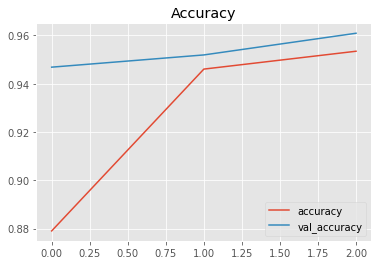

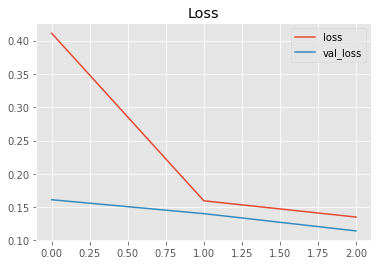

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
model_path = rep_df+'/220114_model_resnet50_80percentdata_col_flip'
#model_path = rep_df+'/220109_model_resnet50_20percentdata_seg'
model.save(model_path)

INFO:tensorflow:Assets written to: /gdrive/MyDrive/Colab_Notebooks/Datascientest_epyphyte//220114_model_resnet50_80percentdata_col_flip/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Chargement Model

In [ ]:
#model_path = rep_df+'/220109_model_resnet50_80percentdata'
#model_path = rep_df+'/220109_model_resnet50_80percentdata_seg_flip'
model_path = rep_df+'/220114_model_resnet50_80percentdata_col_flip'
model = load_model(model_path)

## Evaluation / prediction : X_Test

In [ ]:
# Evaluation du model
#results = model.evaluate(test_gen) #, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# OR
#loss, acc = model.evaluate(test_images, test_labels, verbose=2)
#print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

272/272 [==============================] - 1713s 6s/step - loss: 0.1077 - accuracy: 0.9673
    Test Loss: 0.10767
Test Accuracy: 96.73%


In [ ]:
# Prediction sur X_test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
y_test_indice, y_pred_indice, y_test_nom, y_pred_nom, filemames = predict_test_datagen_X_test(model, test_datagen, X_test, chemin_col)

# Classification report
print(classification_report(y_test_indice, y_pred_indice))

# Afficher matrice de consfusion / heatmap : indice_vs_nom = True pour matrice avec indice et non nom  indice_vs_nom
matrice_confusion(y_test_indice, y_pred_indice, y_test_nom, y_pred_nom, False)

# Afficher les resultats / images labels reels et predictions (nombre de ligne determine le nombre d'images : 5 par ligne) 
Resultat_afficher_image(filenames, y_test_nom, y_pred_nom, 2)

## Evaluation / prediction : autres

### Prediction sur df_chemin_court_test

In [ ]:
df_chemin_court_test.shape

(10861, 6)

In [ ]:
X_train2, X_test2, _, _ = train_test_split(df_chemin_court_test,df_chemin_court_test, test_size=0.05, stratify=df_chemin_court_test[classe_col])
X_test2.shape

(544, 6)

Found 544 validated image filenames belonging to 38 classes.
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.94      0.94      0.94        16
           4       1.00      1.00      1.00        15
           5       0.90      0.90      0.90        10
           6       1.00      1.00      1.00         9
           7       0.62      1.00      0.77         5
           8       1.00      0.92      0.96        12
           9       1.00      0.80      0.89        10
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        12
          12       1.00      0.93      0.96        14
          13       1.00      1.00      1.00        11
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00        55
          16       1

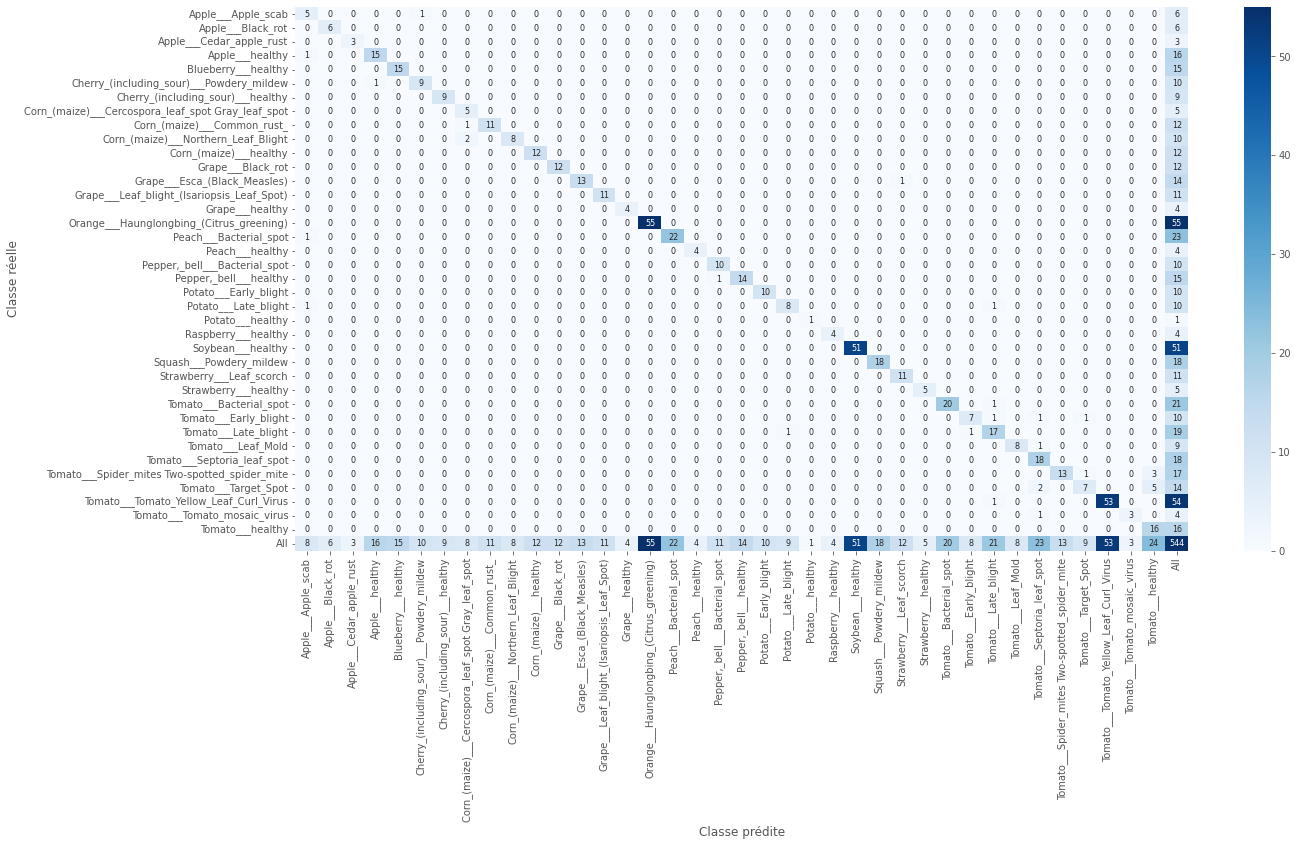

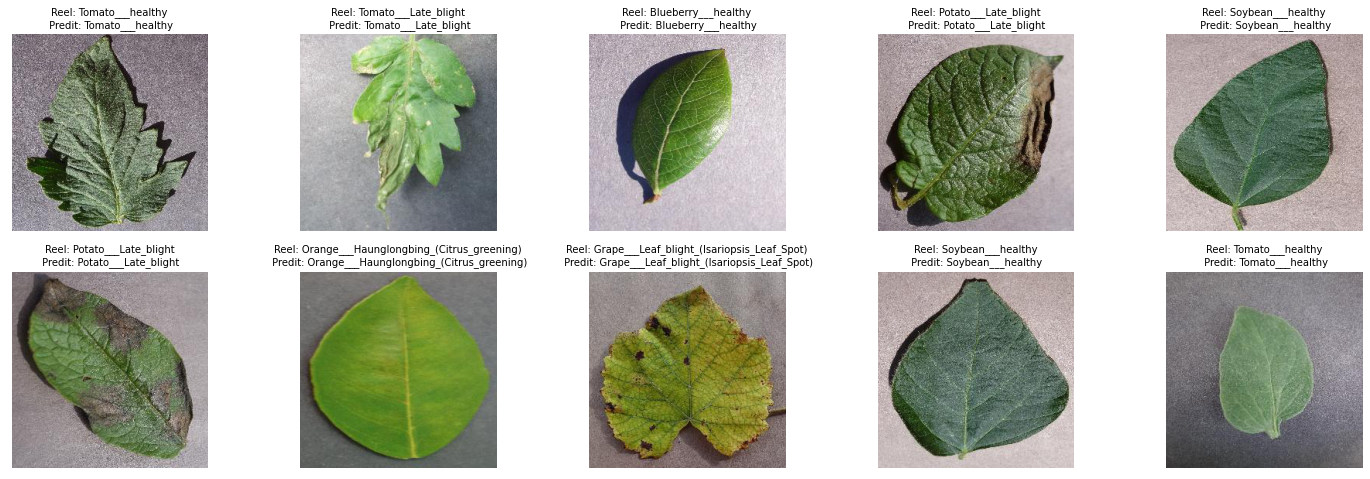

In [ ]:
# Prediction sur df_chemin_court_test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
y_test_indice2, y_pred_indice2, y_test_nom2, y_pred_nom2, filenames = predict_test_datagen_X_test(model, test_datagen, X_test2, chemin_col)

# Classification report
print(classification_report(y_test_indice2, y_pred_indice2))
#print(classification_report(y_test_nom2, y_pred_nom2))

# Afficher matrice de consfusion / heatmap : indice_vs_nom = True pour matrice avec indice et non nom  indice_vs_nom
matrice_confusion(y_test_indice2, y_pred_indice2,y_test_nom2, y_pred_nom2, False)

# Afficher les resultats / images labels reels et predictions (nombre de ligne determine le nombre d'images : 5 par ligne) 
Resultat_afficher_image(filenames, y_test_nom2, y_pred_nom2, 2)

In [ ]:
matrice_confusion2(pd.Series(y_test_nom2), pd.Series(y_pred_nom2), 'reelle', 'predite', figsize=(30,10), cmap='Blues')

### Prediction sur df_reel - test

In [ ]:
chemin_image = '/gdrive/MyDrive/epyphyte/donnees/test/'  # 53 photos réelles
# '/gdrive/MyDrive/epyphyte/donnees/test2' # 53 photos color
# '/gdrive/MyDrive/epyphyte/donnees/test3' # 53 photos segmented

import os
df_reel = pd.DataFrame()
for (repertoire, sousRepertoires, fichiers) in os.walk(chemin_image):
    df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
    df_temp['dossier'] = repertoire
    df_reel = pd.concat([df_reel, df_temp], axis = 0)

df_reel['chemin_color'] = df_reel['dossier'] +'/'+ df_reel['fichier']
df_reel['plante_maladie']=[x[len(chemin_image):] for x in df_reel.dossier]
df_reel['plante']=[x.split('___')[0] for x in df_reel.plante_maladie]   
df_reel['maladie']=[x.split('___')[1] for x in df_reel.plante_maladie]
df_reel.head(1)

,fichier,dossier,chemin_color,plante_maladie,plante,maladie
0,Mildiou1.jpg,/gdrive/MyDrive/epyphyte/donnees/test/Potato__...,/gdrive/MyDrive/epyphyte/donnees/test/Potato__...,Potato___Late_blight,Potato,Late_blight


Found 53 validated image filenames belonging to 38 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.30      0.43      0.35         7
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
          11       1.00      0.29      0.44         7
          18       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         4
          25       0.00      0.00      0.00         9
          26       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         6
          29       0.00      0.00      0.00        14
          30       0.00      0.00      0.00         0
          31       0.00      0.00      0.00         6
          32       0.00      0.00      0.00         0

    accuracy                           0.09        53
   macro avg       0.09      0.05      0.06        53
weighted avg       0.17      0.09      0.11        53

Classe prédite   0  1  2 

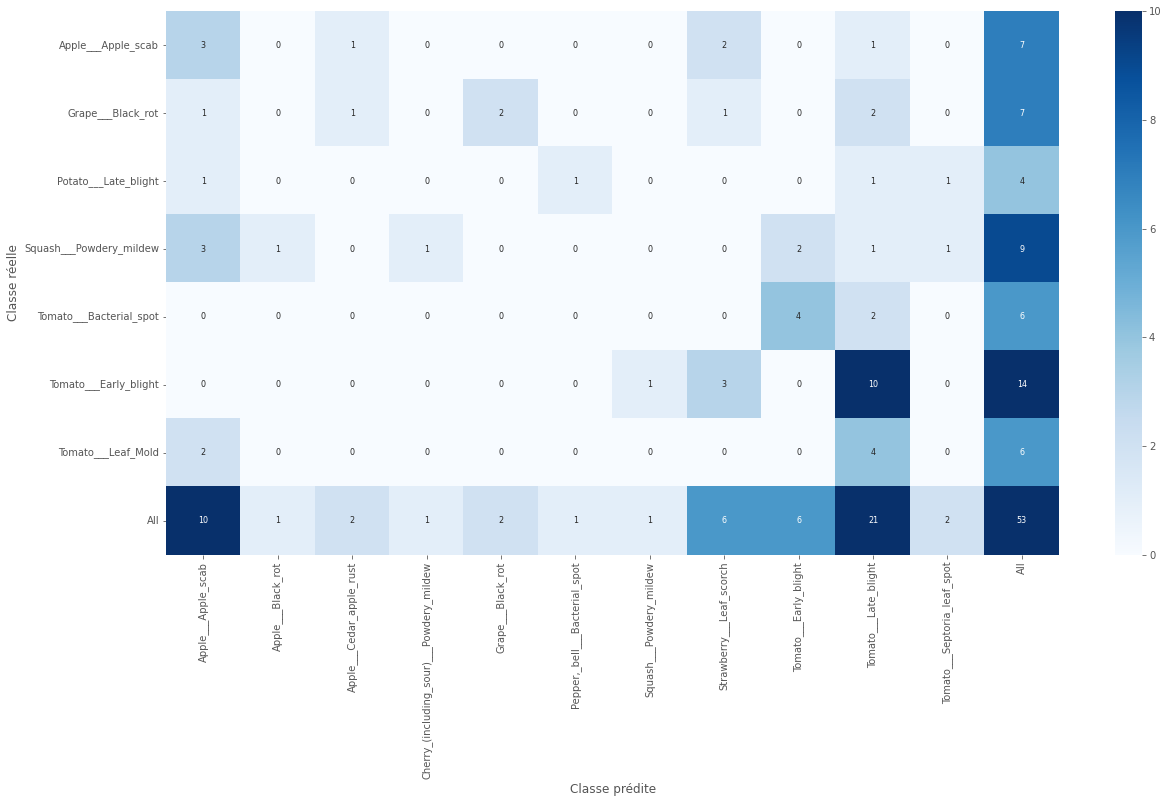

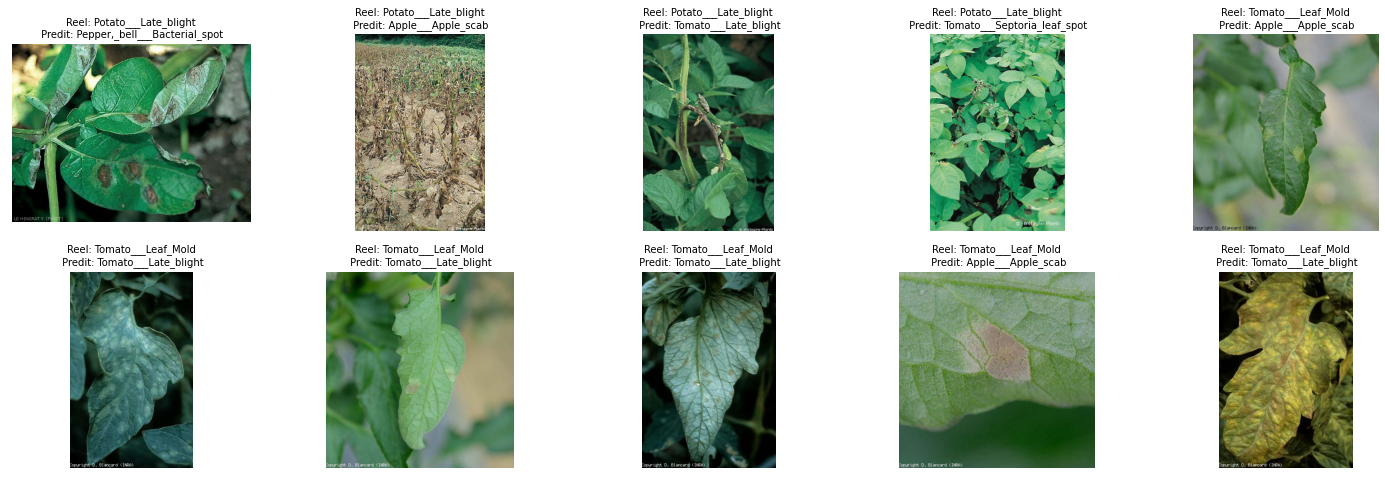

In [ ]:
# Prediction sur df_reel / Chemin_color
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
y_test_indice2, y_pred_indice2, y_test_nom2, y_pred_nom2, filenames = predict_test_datagen_X_test(model, test_datagen, df_reel, 'chemin_color')

# Classification report
print(classification_report(y_test_indice2, y_pred_indice2))
#print(classification_report(y_test_nom2, y_pred_nom2))

# Afficher matrice de consfusion / heatmap : indice_vs_nom = True pour matrice avec indice et non nom  indice_vs_nom
matrice_confusion(y_test_indice2, y_pred_indice2,y_test_nom2, y_pred_nom2, False)
print(pd.crosstab(y_test_indice2, y_pred_indice2, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True))
#print(pd.crosstab(y_test_nom2, y_pred_nom2, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True))

# Afficher les resultats / images labels reels et predictions (nombre de ligne determine le nombre d'images : 5 par ligne) 
Resultat_afficher_image(filenames, y_test_nom2, y_pred_nom2, 2)

### Prediction sur df_reel - test4

In [ ]:
chemin_image = '/gdrive/MyDrive/epyphyte/donnees/test4/'  # 26 photos réelles
# '/gdrive/MyDrive/epyphyte/donnees/test2' # 53 photos color
# '/gdrive/MyDrive/epyphyte/donnees/test3' # 53 photos segmented

import os
df_reel = pd.DataFrame()
for (repertoire, sousRepertoires, fichiers) in os.walk(chemin_image):
    df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
    df_temp['dossier'] = repertoire
    df_reel = pd.concat([df_reel, df_temp], axis = 0)

df_reel['chemin_color'] = df_reel['dossier'] +'/'+ df_reel['fichier']
df_reel['plante_maladie']=[x[len(chemin_image):] for x in df_reel.dossier]
df_reel['plante']=[x.split('___')[0] for x in df_reel.plante_maladie]   
df_reel['maladie']=[x.split('___')[1] for x in df_reel.plante_maladie]
df_reel.head(1)

,fichier,dossier,chemin_color,plante_maladie,plante,maladie
0,IMG_20220111_134020.jpg,/gdrive/MyDrive/epyphyte/donnees/test4/Tomato_...,/gdrive/MyDrive/epyphyte/donnees/test4/Tomato_...,Tomato___healthy,Tomato,healthy


In [ ]:
df_reel.shape

(26, 6)

Found 26 validated image filenames belonging to 38 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00       0.0
          19       0.00      0.00      0.00       0.0
          21       0.00      0.00      0.00       0.0
          26       0.00      0.00      0.00       0.0
          30       0.00      0.00      0.00       0.0
          35       0.00      0.00      0.00       0.0
          37       0.00      0.00      0.00      26.0

    accuracy                           0.00      26.0
   macro avg       0.00      0.00      0.00      26.0
weighted avg       0.00      0.00      0.00      26.0

Classe prédite  0  2  7  15  19  21  26  30  35  All
Classe réelle                                       
37              2  2  1   2   1   1   1  12   4   26
All             2  2  1   2   1   1   1  12   4   26


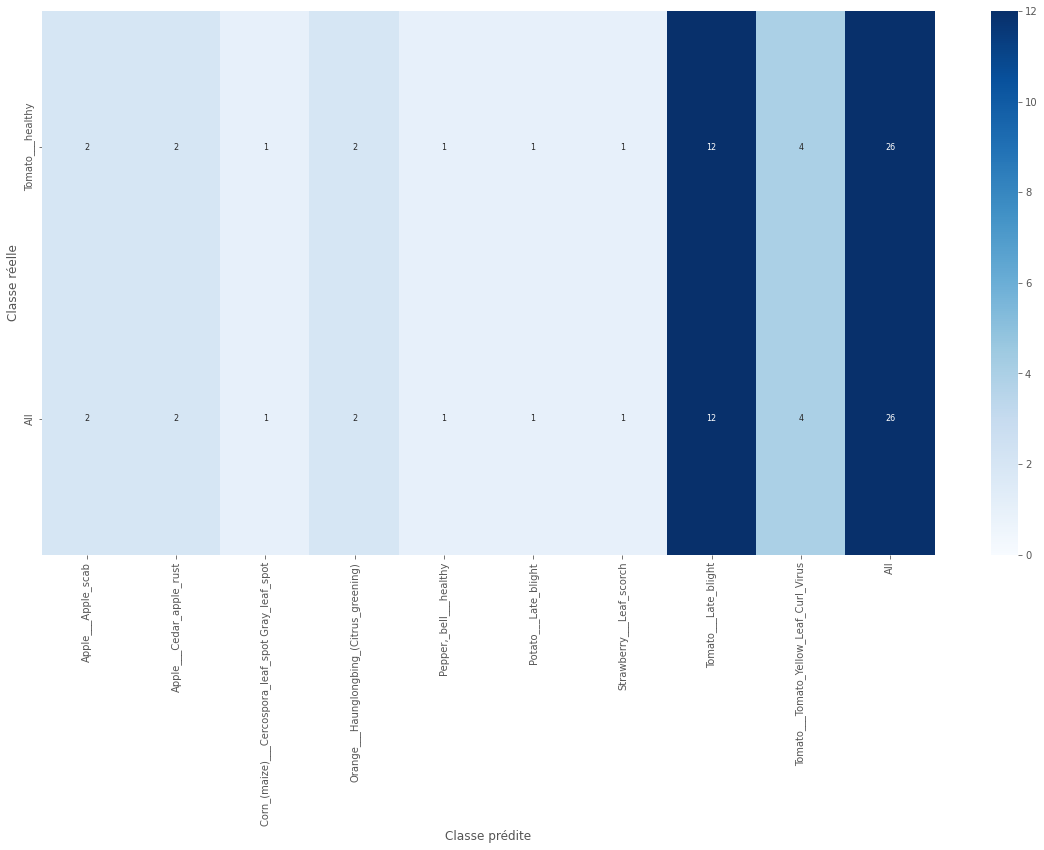

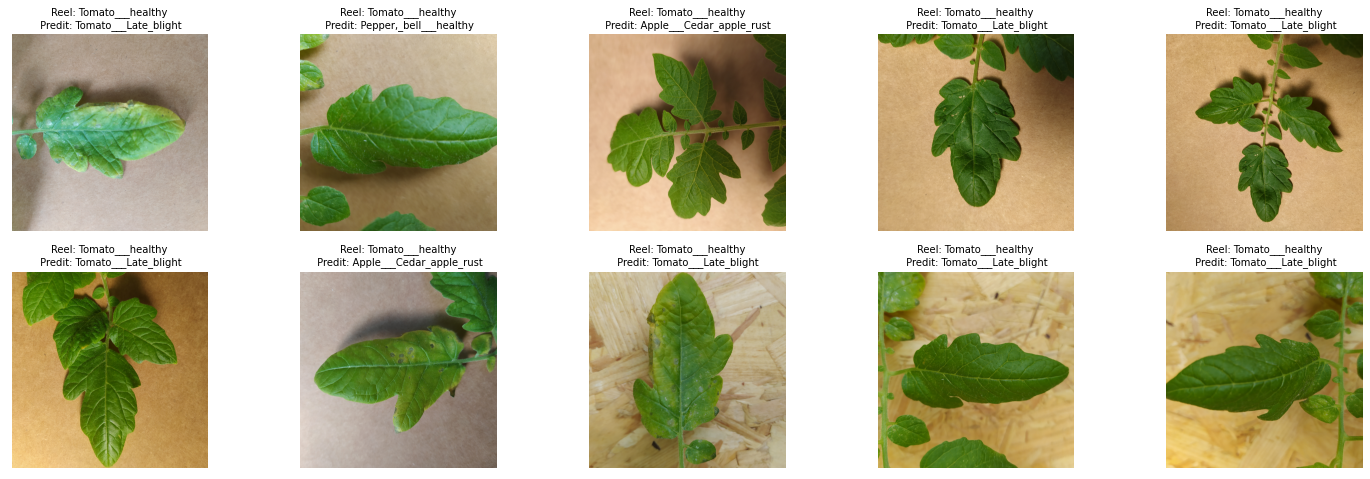

In [ ]:
# Prediction sur df_reel / Chemin_color
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
y_test_indice2, y_pred_indice2, y_test_nom2, y_pred_nom2, filenames = predict_test_datagen_X_test(model, test_datagen, df_reel, 'chemin_color')

# Classification report
print(classification_report(y_test_indice2, y_pred_indice2))
#print(classification_report(y_test_nom2, y_pred_nom2))

# Afficher matrice de consfusion / heatmap : indice_vs_nom = True pour matrice avec indice et non nom  indice_vs_nom
matrice_confusion(y_test_indice2, y_pred_indice2,y_test_nom2, y_pred_nom2, False)
print(pd.crosstab(y_test_indice2, y_pred_indice2, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True))
#print(pd.crosstab(y_test_nom2, y_pred_nom2, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True))

# Afficher les resultats / images labels reels et predictions (nombre de ligne determine le nombre d'images : 5 par ligne) 
Resultat_afficher_image(filenames, y_test_nom2, y_pred_nom2, 2)

# FIN